## 11-9. 프로젝트 : 주식 예측에 도전해 보자

## 목차
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해보기
8. 회고

## 루브릭
|평가문항|상세기준|
|:---|:---|
|1. 시계열의 안정성이 충분히 확인되었는가?|	플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

### 시계열 데이터 준비

<ul><li>칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  </li><li>날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.</li><li>우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)</li></ul>

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

path = os.getenv('HOME')+"/aiffel/aiffel_project/exploration_11/stock_prediction/data/005930.KS.csv"
df = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 각종 전처리 수행

<ul>
    <li>결측치 처리</li>
    <li>로그 변환</li>
</ul>

In [7]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [8]:
ts_log = np.log(ts)

### 시계열 안정성 분석

<ul><li>정성적 그래프 분석  </li><li>정량적 Augmented Dicky-Fuller Test  </li><li>시계열 분해(Time Series Decomposition)  </li><li>Residual 안정성 확인</li></ul>

In [11]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [10]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

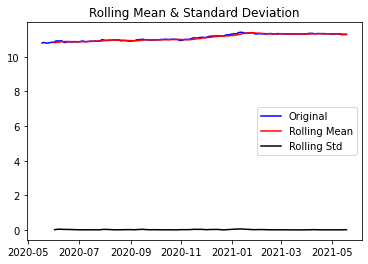

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


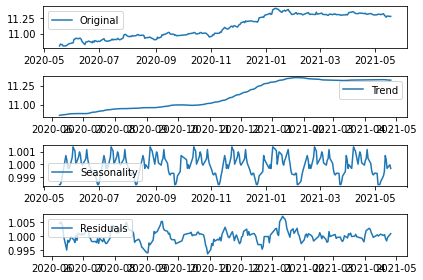

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 학습, 테스트 데이터셋 생성

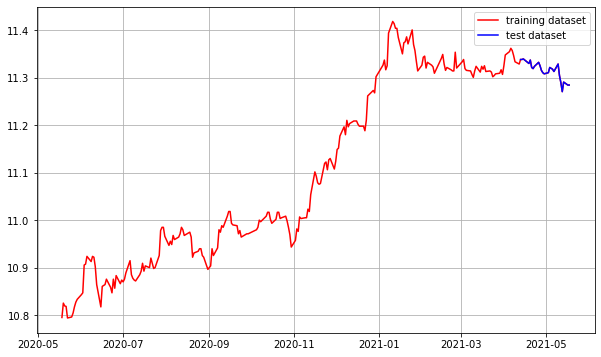

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### 적정 ARIMA 모수 찾기

- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

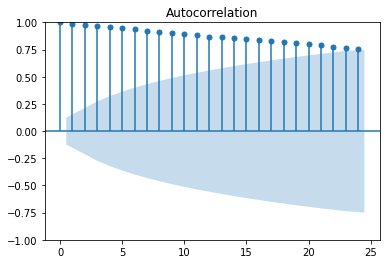

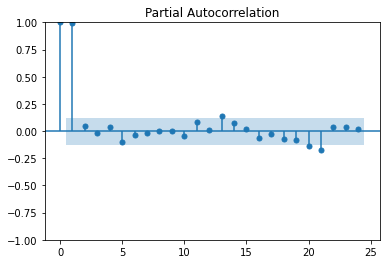

In [17]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


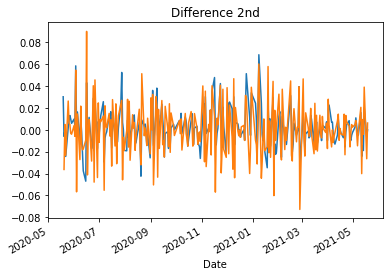

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [25]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        08:56:44   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

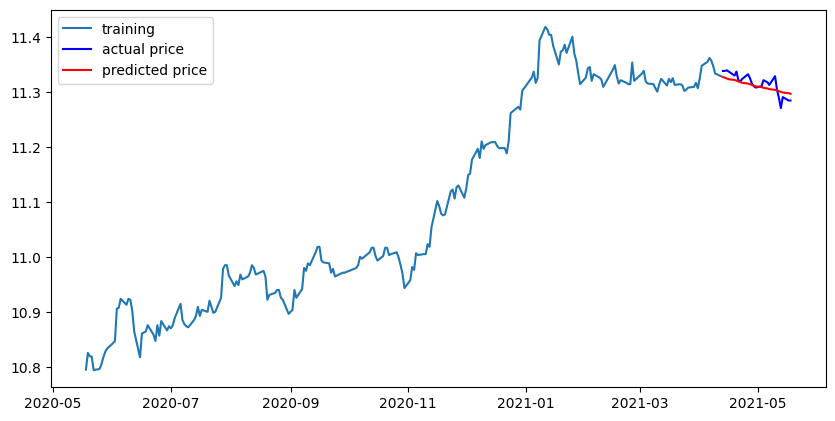

In [26]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


### 다른 종목 예측해 보기

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action='ignore')
# 세팅 함수
def setting(path):
    print('데이터 준비')
    df = pd.read_csv(path, index_col='Date', parse_dates=True)
    ts = df['Close']
    print(ts.head())
    ts = ts.interpolate(method='time')
    print(ts[ts.isna()])
    ts_log = np.log(ts)
    return df, ts, ts_log

In [4]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    print("정성적 그래프 분석")
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [5]:
from statsmodels.tsa.stattools import adfuller
#정량적 Augmented Dicky-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [6]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
def TSD(ts_log):
    print("시계열 분해")
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return trend, seasonal, residual

In [7]:
def cut_train_test(ts_log):
    print("train, test 분리")
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    
    return train_data, test_data

In [8]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def acf_pacf_plot(ts_log):
    print("Autocorrelation 그래프 그리기")
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    print("Partial Autocorrelation 그래프 그리기")
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()

def Differencing(ts_log):
    # 1차 차분 구하기
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)

    # 혹시 필요한 경우 2차 차분 구하기
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
    
    return diff_1, diff_2

In [9]:
# 모델 만들기
from statsmodels.tsa.arima.model import ARIMA
def bulid_model(train_data, num):
    # Build and Train  Model
    model = ARIMA(train_data, order=(num, 0, 1))  
    fitted_m = model.fit() 
    print("모델")
    print(fitted_m.summary())
    return model, fitted_m

In [10]:
def model_fit(fitted_m, train_data, test_data):
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    print("측결과")
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc, fc_series

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# MSE, MAE, RMSE, MAPE
def result(test_data, fc):
    print("MSE, MAE, RMSE, MAPE")
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
    
    return mse, mae, rmse, mape

### sk하이닉스

데이터 준비
Date
2021-02-10    126000.0
2021-02-15    132000.0
2021-02-16    132500.0
2021-02-17    130000.0
2021-02-18    126000.0
Name: Close, dtype: float64
Series([], Name: Close, dtype: float64)
정성적 그래프 분석


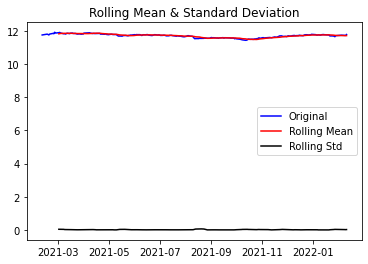

Results of Dickey-Fuller Test:
Test Statistic                  -1.557600
p-value                          0.504850
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64
시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                  -5.511192
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64
train, test 분리
Autocorrelation 그래프 그리기
Partial Autocorrelation 그래프 그리기


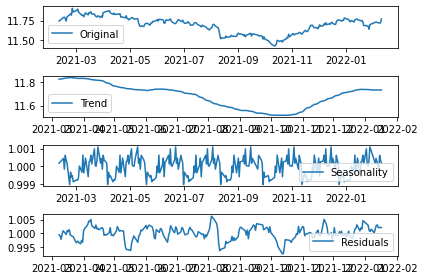

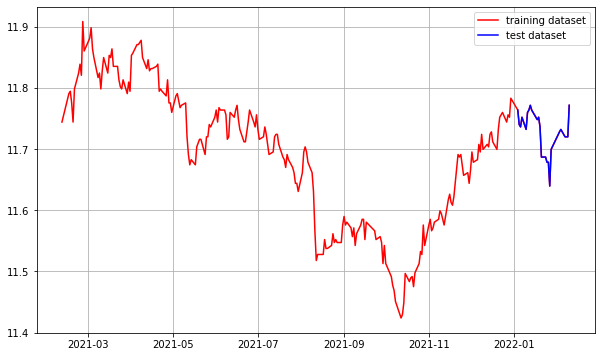

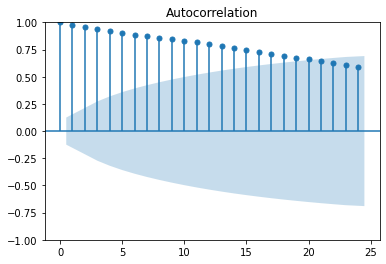

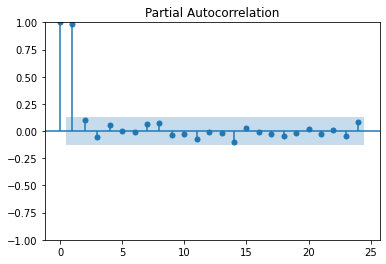

In [29]:
# 파일위치
path = os.getenv('HOME')+"/aiffel/aiffel_project/exploration_11/stock_prediction/data/000660.KS.csv"
df, ts, ts_log = setting(path)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
trend, seasonal, residual = TSD(ts_log)

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 훈련 데이터, 테스트 데이터 분할
train_data, test_data = cut_train_test(ts_log)

# ACF, PACF 그려보기 -> p,q 구하기
acf_pacf_plot(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.689661e+01
p-value                        1.035319e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.139857e+00
p-value                        1.035170e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64
모델
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 531.791
Date:                Tue, 15 Feb 2022   AIC         

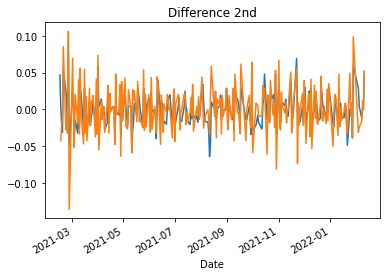

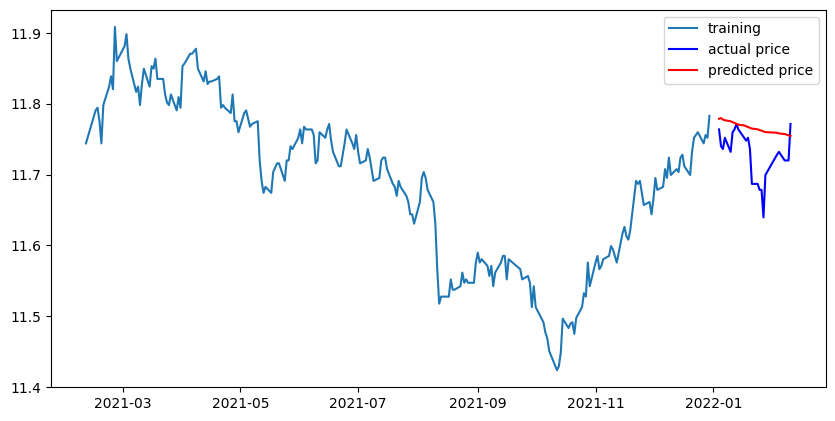

MSE, MAE, RMSE, MAPE
MSE:  35797186.72276609
MAE:  4819.359040185991
RMSE:  5983.075022324731
MAPE: 3.98%


In [30]:
# 1차, 2차 차분 구하기
diff_1, diff_2 = Differencing(ts_log)

# 모델 만들기
num = 3
model, fitted_m = bulid_model(train_data, num)

# 테스트
fc, fc_series = model_fit(fitted_m, train_data, test_data)

# MSE, MAE, RMSE, MAPE
mse, mae, rmse, mape = result(test_data, fc)

<code>p = 2</code>인경우 MAPE: 4.07%

<code>p = 3</code>인경우 MAPE: 3.98%

### KT

데이터 준비
Date
2021-02-15    24700.0
2021-02-16    26550.0
2021-02-17    26650.0
2021-02-18    26500.0
2021-02-19    26650.0
Name: Close, dtype: float64
Series([], Name: Close, dtype: float64)
정성적 그래프 분석


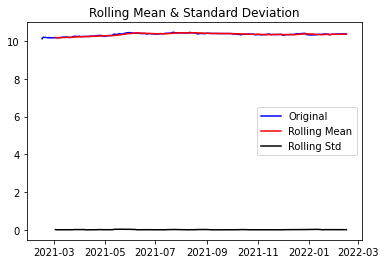

Results of Dickey-Fuller Test:
Test Statistic                  -3.039384
p-value                          0.031377
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64
시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                  -5.379552
p-value                          0.000004
#Lags Used                       5.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64
train, test 분리
Autocorrelation 그래프 그리기
Partial Autocorrelation 그래프 그리기


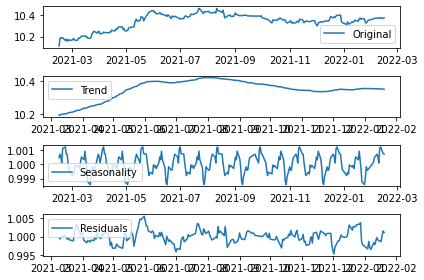

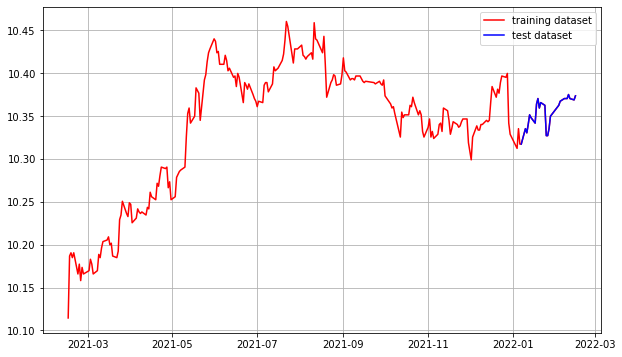

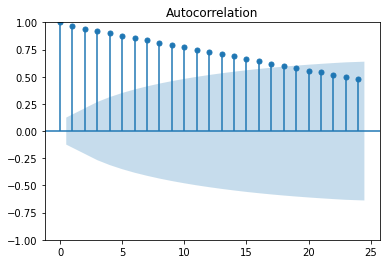

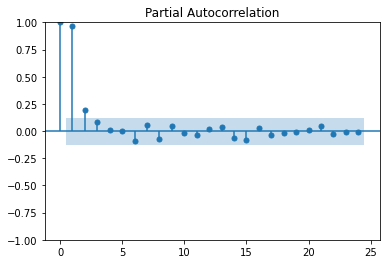

In [43]:
# 파일위치
path = os.getenv('HOME')+"/aiffel/aiffel_project/exploration_11/stock_prediction/data/030200.KS.csv"
df, ts, ts_log = setting(path)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
trend, seasonal, residual = TSD(ts_log)

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 훈련 데이터, 테스트 데이터 분할
train_data, test_data = cut_train_test(ts_log)

# ACF, PACF 그려보기 -> p,q 구하기
acf_pacf_plot(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.281833e+01
p-value                        6.230442e-24
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.079816e+00
p-value                        1.471710e-12
#Lags Used                     1.200000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64
모델
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                ARIMA(20, 0, 1)   Log Likelihood                 631.319
Date:                Tue, 15 Feb 2022   AIC         

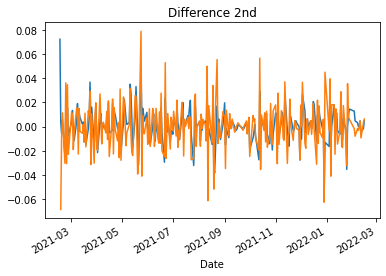

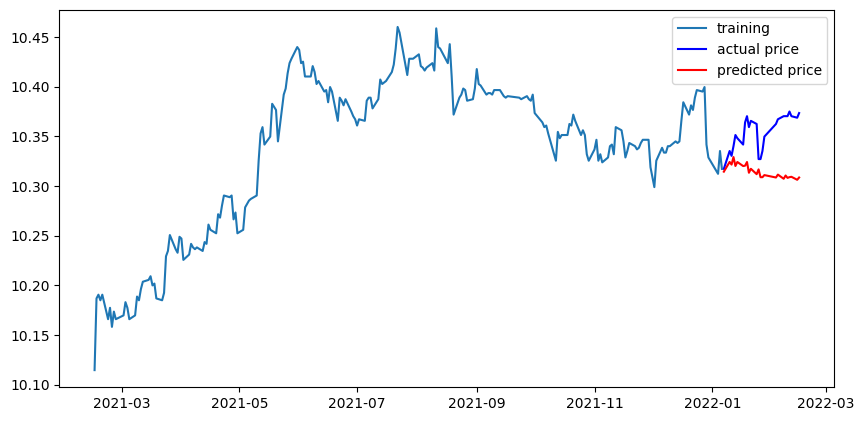

MSE, MAE, RMSE, MAPE
MSE:  1898754.5142335691
MAE:  1220.3123887159475
RMSE:  1377.9530159746264
MAPE: 3.85%


In [54]:

# 1차, 2차 차분 구하기
diff_1, diff_2 = Differencing(ts_log)

# 모델 만들기
num = 20
model, fitted_m = bulid_model(train_data, num)

# 테스트
fc, fc_series = model_fit(fitted_m, train_data, test_data)

# MSE, MAE, RMSE, MAPE
mse, mae, rmse, mape = result(test_data, fc)

- KT의 경우 <code>p = 20</code>일때 MAPE가 3.85%로 가장 낮은 결과 확인

### NAVER(5년)

데이터 준비
Date
2017-02-15    154600.0
2017-02-16    155400.0
2017-02-17    156000.0
2017-02-20    156200.0
2017-02-21    158000.0
Name: Close, dtype: float64
Series([], Name: Close, dtype: float64)
정성적 그래프 분석


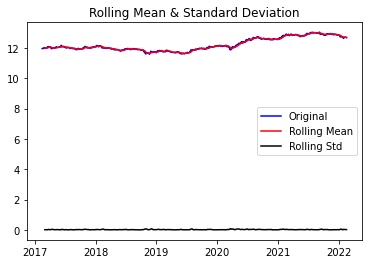

Results of Dickey-Fuller Test:
Test Statistic                   -0.552931
p-value                           0.881267
#Lags Used                        1.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64
시계열 분해
Results of Dickey-Fuller Test:
Test Statistic                -1.003251e+01
p-value                        1.571433e-17
#Lags Used                     1.800000e+01
Number of Observations Used    1.176000e+03
Critical Value (1%)           -3.435923e+00
Critical Value (5%)           -2.864001e+00
Critical Value (10%)          -2.568080e+00
dtype: float64
train, test 분리
Autocorrelation 그래프 그리기
Partial Autocorrelation 그래프 그리기


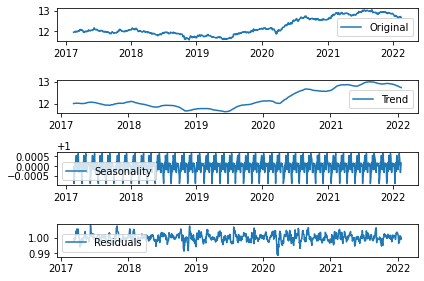

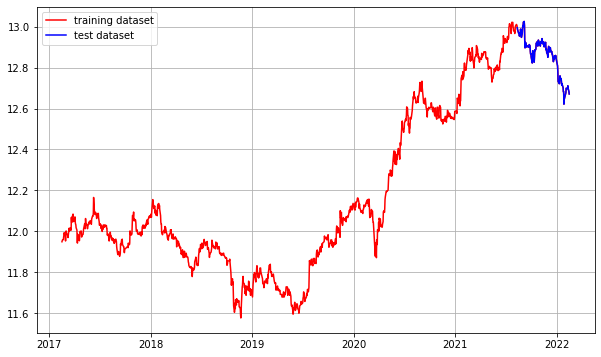

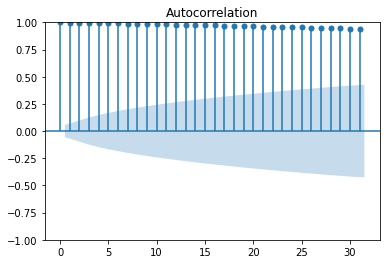

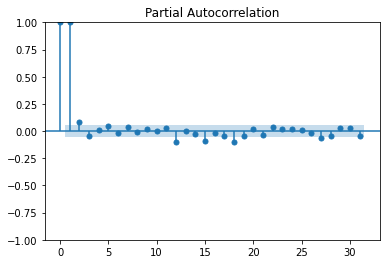

In [55]:
# 파일위치
path = os.getenv('HOME')+"/aiffel/aiffel_project/exploration_11/stock_prediction/data/035420.KS.csv"
df, ts, ts_log = setting(path)

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
trend, seasonal, residual = TSD(ts_log)

# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 훈련 데이터, 테스트 데이터 분할
train_data, test_data = cut_train_test(ts_log)

# ACF, PACF 그려보기 -> p,q 구하기
acf_pacf_plot(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -37.712849
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1223.000000
Critical Value (1%)              -3.435708
Critical Value (5%)              -2.863906
Critical Value (10%)             -2.568030
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.594659e+01
p-value                        7.437589e-29
#Lags Used                     1.600000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64
모델
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1102
Model:                ARIMA(18, 0, 1)   Log Likelihood                2693.147
Date:                Tue, 15 Feb 2022   AIC                

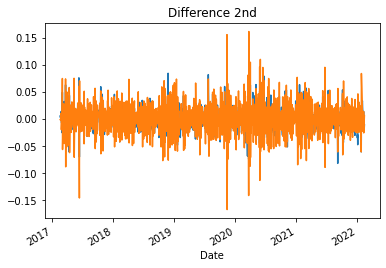

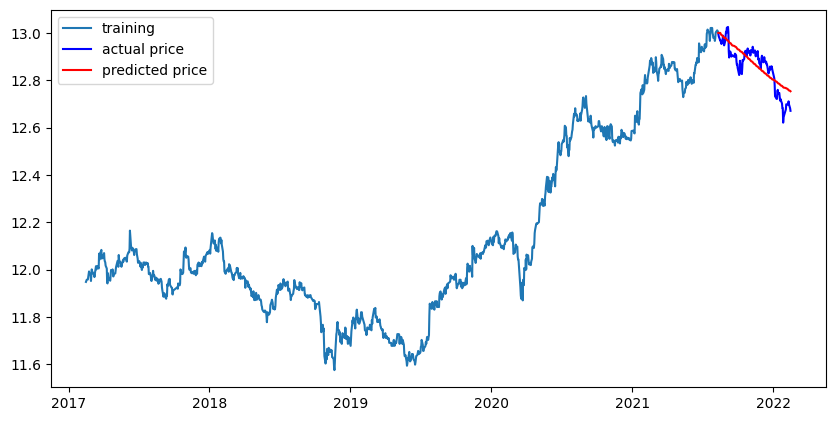

MSE, MAE, RMSE, MAPE
MSE:  377455242.15143603
MAE:  17449.897365160185
RMSE:  19428.207383889952
MAPE: 4.64%


In [63]:
# 1차, 2차 차분 구하기
diff_1, diff_2 = Differencing(ts_log)

# 모델 만들기
num = 18
model, fitted_m = bulid_model(train_data, num)

# 테스트
fc, fc_series = model_fit(fitted_m, train_data, test_data)

# MSE, MAE, RMSE, MAPE
mse, mae, rmse, mape = result(test_data, fc)

- 1년 데이터와 비교시 상당히 낮은 MAPE 값을 가져오는 것을 확인 할 수 있다.
- <code>p = 18</code>일때 가장 낮은 MAPE 값이 나왔습니다.

## 회고

#### 삼성전자
- <code>p = 2</code>일때 가장 낮은 MAPE 값 1.03%이 나왔습니다.

#### sk하이닉스 
- <code>p = 3</code>일때 가장 낮은 MAPE 값 3.98%이 나왔습니다.

#### kt
- <code>p = 20</code>일때 가장 낮은 MAPE 값 3.85%이 나왔습니다.

#### naver
- 1년 데이터 사용
- naver 주식도 해보았지만 후반에 급락을 하여 이전 데이터를 가지고 예측이 힘든것 같습니다.
- naver의 경우 가장 낮은 MAPE 값은 약 14.7% 정도 입니다.

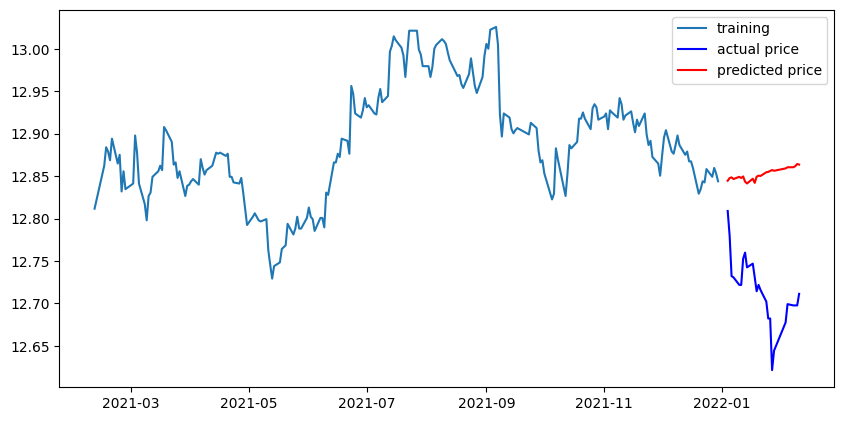

- 데이터가 증가할 경우 어떠한 결과를 출력할지 궁금하여 5년치 데이터를 가져와 테스트 해보았습니다.
- 결과 <code>p = 18</code>일때 가장 낮은 MAPE 값 4.64%이 나왔습니다.
- 데이터가 많아야 더 정확한 예측이 가능하다는 것을 확인 하였습니다.

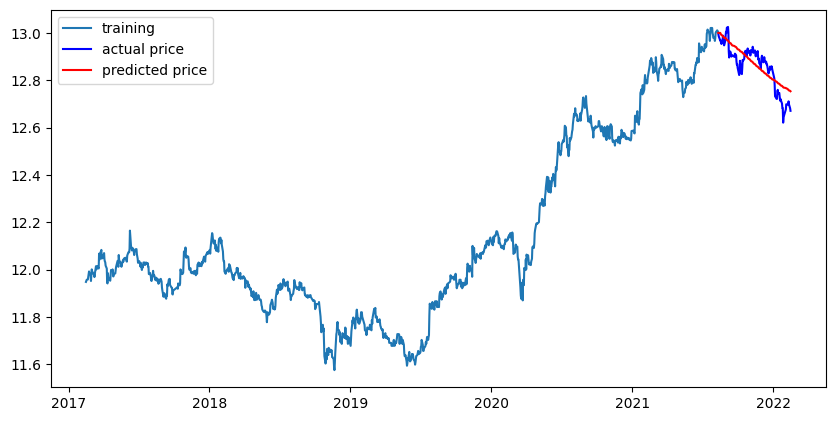



- 1년치 데이터로 예측할 경우 주식에 변동이 크지 않을 경우에 예측이 가능하고 급락등이 발생하면 예측이 어렵다는 사실을 확인했습니다.
- 네이버와 같이 주식이 급락등이 있다면 더 많은 양의 데이터가 있어야 비슷하게 예측할 수 있는것 같습니다.